<a href="https://colab.research.google.com/github/Fall-Llihc/Kode_TimGacor/blob/main/Pre_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Smart Portfolio Rebalancing: AI-Driven Volatility Forecast and Investment Optimization during Global Conflicts**</center>


# ***Get the Data***
---

In [ ]:
# download list ticker setiap sektor yang telah dibuat
!gdown 1f37oUGoe65yTce8haTtUCqzY0Bc0wjLo

Downloading...
From: https://drive.google.com/uc?id=1f37oUGoe65yTce8haTtUCqzY0Bc0wjLo
To: /content/Sector-Faktur.csv
100% 3.63k/3.63k [00:00<00:00, 12.5MB/s]


In [ ]:
import yfinance as yf
import pandas as pd
import time
import warnings

# --- Pengaturan Awal dari File CSV ---
# Nonaktifkan peringatan yang tidak relevan
warnings.filterwarnings('ignore')

# Baca file faktur
try:
    df_faktur = pd.read_csv('Sector-Faktur.csv')

    # Membuat dictionary untuk memetakan Ticker ke Sektornya
    ticker_to_sector = pd.Series(
        df_faktur.Sector.values,
        index=df_faktur.Faktur.str.strip()  # <-- KITA TAMBAHKAN .str.strip() DI SINI
    ).to_dict()

    # Membuat daftar ticker dengan menambahkan '.JK'
    tickers = [f"{ticker}.JK" for ticker in ticker_to_sector.keys()]

    print("\n📊 Contoh Data Sector-Faktur.csv (5 teratas)\n")
    print(df_faktur.head(5))

except FileNotFoundError:
    print("❌ FATAL: File 'Sector-Faktur.csv' tidak ditemukan. Pastikan file ada di direktori yang sama.")
    tickers = [] # Set tickers ke list kosong agar skrip tidak error
    ticker_to_sector = {}


📊 Contoh Data Sector-Faktur.csv (5 teratas)

      Sector Faktur
0  Kesehatan  KLBF 
1  Kesehatan  CARE 
2  Kesehatan  SIDO 
3  Kesehatan  OMED 
4  Kesehatan  SAME 


In [ ]:
# --- Membuat Fungsi Lebih Dinamis ---
def download_ticker_data(ticker, sector, start_date="2015-01-01", end_date="2025-06-26"):
    """Download data untuk satu ticker dengan error handling dan sektor dinamis"""
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)

        if not hist.empty:
            df = hist.reset_index()
            df['Ticker'] = ticker.replace('.JK', '')
            df['Sector'] = sector  # Menggunakan parameter sektor
            df['Date'] = pd.to_datetime(df['Date']).dt.date

            columns_order = ['Date', 'Ticker', 'Sector', 'Open', 'High', 'Low', 'Close', 'Volume']
            df = df[columns_order]

            numeric_cols = ['Open', 'High', 'Low', 'Close']
            df[numeric_cols] = df[numeric_cols].round(2)
            df['Volume'] = df['Volume'].astype('int64')

            return df, True, "Success"
        else:
            return None, False, "No data available"

    except Exception as e:
        return None, False, str(e)

# --- Proses Download (Logika Inti Tetap Sama) ---
if tickers:
    print("🚀 Memulai download data berdasarkan 'Sector-Faktur.csv'...")
    print(f"📊 Total ticker yang akan diproses: {len(tickers)}")
    print("=" * 60)

    successful_data = []
    ticker_info = []

    for i, ticker_jk in enumerate(tickers, 1):
        # Ambil nama ticker bersih dan sektornya dari dictionary
        ticker_clean = ticker_jk.replace('.JK', '')
        sector_name = ticker_to_sector.get(ticker_clean, 'Unknown') # Default ke 'Unknown' jika tidak ditemukan

        print(f"[{i:3d}/{len(tickers)}] {ticker_jk:<10} ({sector_name})", end=" ")

        data, success, message = download_ticker_data(ticker_jk, sector_name)

        if success:
            successful_data.append(data)
            records = len(data)
            date_range = f"{data['Date'].min()} to {data['Date'].max()}"
            print(f"✅ {records:5d} records ({date_range})")
            status_msg = 'Success'
        else:
            records = 0
            date_range = "N/A"
            print(f"❌ {message}")
            status_msg = message

        ticker_info.append({
            'Ticker': ticker_clean,
            'Sector': sector_name,
            'Records': records,
            'Start_Date': data['Date'].min() if success else None,
            'End_Date': data['Date'].max() if success else None,
            'Status': status_msg
        })

        time.sleep(0.5) # Sedikit delay untuk menghormati server API

    print("=" * 60)

    # --- MODIFIKASI 3: Proses Hasil dengan Nama File Umum ---
    if successful_data:
        print(f"📈 Menggabungkan data dari {len(successful_data)} ticker...")
        combined_df = pd.concat(successful_data, ignore_index=True)
        combined_df = combined_df.sort_values(['Date', 'Ticker']).reset_index(drop=True)

        filename = "data_saham_gabungan.csv" # Nama file output lebih umum
        combined_df.to_csv(filename, index=False)

        print("\n✅ Data berhasil digabungkan dan disimpan!")
        print(f"📁 File: {filename}")
        print(f"📊 Total records: {len(combined_df):,}")
        print(f"🏢 Jumlah perusahaan: {combined_df['Ticker'].nunique()}")
        print(f"🗓️ Periode: {combined_df['Date'].min()} s/d {combined_df['Date'].max()}")

        print(f"\n📋 Preview data (5 baris pertama):")
        print(combined_df.head().to_string(index=False))

        print(f"\n📊 Summary per ticker:")
        summary_df = pd.DataFrame(ticker_info)

        print("\n✅ Ticker berhasil:")
        print(summary_df[summary_df['Status'] == 'Success'][['Ticker', 'Sector', 'Records']].to_string(index=False))

        failed_summary = summary_df[summary_df['Status'] != 'Success']
        if not failed_summary.empty:
            print("\n❌ Ticker gagal:")
            print(failed_summary[['Ticker', 'Sector', 'Status']].to_string(index=False))

        print(f"\n🎯 Ringkasan Akhir:")
        print(f"   ✅ Berhasil: {len(successful_data)}/{len(tickers)} ticker")
        print(f"   📊 Total data: {len(combined_df):,} records")

    else:
        print("❌ Tidak ada data yang berhasil didownload.")
        print("🔧 Coba periksa koneksi internet atau daftar ticker Anda.")

else:
    print("🏁 Tidak ada ticker untuk diproses. Skrip berhenti.")

print("\n🏁 Selesai!")

🚀 Memulai download data berdasarkan 'Sector-Faktur.csv'...
📊 Total ticker yang akan diproses: 165
[  1/165] KLBF.JK    (Kesehatan) ✅  2582 records (2015-01-02 to 2025-06-25)
[  2/165] CARE.JK    (Kesehatan) ✅  1267 records (2020-03-13 to 2025-06-25)
[  3/165] SIDO.JK    (Kesehatan) ✅  2574 records (2015-01-02 to 2025-06-25)
[  4/165] OMED.JK    (Kesehatan) ✅   622 records (2022-11-08 to 2025-06-25)
[  5/165] SAME.JK    (Kesehatan) ✅  2582 records (2015-01-02 to 2025-06-25)
[  6/165] HEAL.JK    (Kesehatan) ✅  1739 records (2018-05-17 to 2025-06-25)
[  7/165] MDLA.JK    (Kesehatan) ✅    44 records (2025-04-15 to 2025-06-25)
[  8/165] PRAY.JK    (Kesehatan) ✅   622 records (2022-11-08 to 2025-06-25)
[  9/165] MIKA.JK    (Kesehatan) ✅  2517 records (2015-03-24 to 2025-06-25)
[ 10/165] SILO.JK    (Kesehatan) ✅  2574 records (2015-01-02 to 2025-06-25)
[ 11/165] SOHO.JK    (Kesehatan) ✅  1152 records (2020-09-08 to 2025-06-25)
[ 12/165] SRAJ.JK    (Kesehatan) ✅  2582 records (2015-01-02 to 20

In [ ]:
# perbaikan urutan
ordered_columns = ['Date', 'Sector', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
combined_df = combined_df[ordered_columns]
combined_df = combined_df.sort_values(['Date', 'Sector', 'Ticker']).reset_index(drop=True)

combined_df.to_csv("dataset_saham_per-sektor(2015-2025).csv", index=False)

In [ ]:
!zip dataset_new.zip 'dataset_saham_per-sektor(2015-2025).csv'
from google.colab import files
files.download('dataset_new.zip')


updating: dataset_saham_per-sektor(2015-2025).csv (deflated 79%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***Prepare Data***
___

In [ ]:
# Download data yang sudah didapat
!gdown 14ZBLgt3ZuDKij-jfNVzHhMC31QPJRLBp

Downloading...
From: https://drive.google.com/uc?id=14ZBLgt3ZuDKij-jfNVzHhMC31QPJRLBp
To: /content/dataset_saham_per-sektor(2015-2025).csv
100% 21.5M/21.5M [00:00<00:00, 98.9MB/s]


In [ ]:
import pandas as pd
df = pd.read_csv("/content/dataset_saham_per-sektor(2015-2025).csv")
df.shape

(331592, 8)

In [ ]:
df['Sector'].unique()

array(['Basic Materials', 'Consumer Cyclicals', 'Consumer Non-Cyclicals',
       'Energy', 'Financials', 'Industrials', 'Infrastuctures',
       'Kesehatan', 'Properties & Real Estate', 'Technology',
       'Transportation & Logistic'], dtype=object)

In [ ]:
df.head(5)

Date           Sector Ticker    Open    High     Low   Close   Volume
0  2015-01-02  Basic Materials   ANTM  721.25  721.25  700.93  707.70  5997189
1  2015-01-02  Basic Materials   BRMS  270.38  270.38  248.58  251.20  5503394
2  2015-01-02  Basic Materials   BRPT   29.40   30.10   29.40   29.50   300739
3  2015-01-02  Basic Materials   KRAS  458.56  458.56  454.78  456.67   405399
4  2015-01-02  Basic Materials   PSAB  110.00  116.00  109.00  114.00  4908500

# ***Mencari Volatile Setiap Sector***
___

In [ ]:
def calculate_sector_volatility_and_return(df, window=14):
    """
    Menghitung rolling sektor volatility dan rata-rata return sektor berdasarkan return harian masing-masing ticker.

    Args:
        df (pd.DataFrame): Data dengan kolom ['Date', 'Ticker', 'Sector', 'Close']
        window (int): Panjang window rolling volatility per ticker (default=14)

    Returns:
        pd.DataFrame: Dataframe dengan kolom
                      ['Date', 'Sector', 'SectorVolatility_14d', 'SectorReturn_avg']
    """
    df_copy = df.copy()

    # Pastikan kolom Date dalam format datetime
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])

    # Urutkan data (penting untuk kalkulasi rolling)
    df_copy = df_copy.sort_values(by=['Ticker', 'Date'])

    # Hitung return harian per ticker
    df_copy['Return'] = df_copy.groupby('Ticker')['Close'].pct_change()

    # Hitung rolling volatility (standar deviasi dari return) per ticker
    df_copy['Volatility_Individual'] = df_copy.groupby('Ticker')['Return'].rolling(window=window).std().reset_index(0, drop=True)

    # Hitung rata-rata volatilitas dan rata-rata return dari semua saham di sektor yang sama per hari
    sector_metrics = (
        df_copy.groupby(['Date', 'Sector'])[['Volatility_Individual', 'Return']]
        .median()
        .reset_index()
        .rename(columns={
            'Volatility_Individual': f'SectorVolatility_{window}d',
            'Return': 'SectorReturn_avg'
        })
    )

    # Hapus baris dengan nilai NaN yang muncul di awal periode rolling
    sector_metrics = sector_metrics.dropna().reset_index(drop=True)

    # Sort berdasarkan sektor dan date
    sector_metrics = sector_metrics.sort_values(by=['Sector', 'Date']).reset_index(drop=True)

    return sector_metrics

In [ ]:
print("⚙️  Menghitung volatilitas untuk setiap sektor (periode 14 hari)...")

# Panggil fungsi yang sudah kita definisikan
sector_vol = calculate_sector_volatility_and_return(df, window=7)

print("✅ Kalkulasi selesai!")


⚙️  Menghitung volatilitas untuk setiap sektor (periode 14 hari)...
✅ Kalkulasi selesai!


In [ ]:
print("\n📊 Hasil Akhir - Volatilitas Rata-Rata per Sektor (5 baris pertama):")
# Menampilkan hasil dengan format yang lebih rapi
sector_vol.head()


📊 Hasil Akhir - Volatilitas Rata-Rata per Sektor (5 baris pertama):


Date           Sector  SectorVolatility_14d  SectorReturn_avg
0 2015-01-22  Basic Materials              0.017752          0.002377
1 2015-01-23  Basic Materials              0.016789          0.002127
2 2015-01-26  Basic Materials              0.016342         -0.005298
3 2015-01-27  Basic Materials              0.016224          0.000000
4 2015-01-28  Basic Materials              0.015795         -0.001083

In [ ]:
print("\n📊 Hasil Akhir - Volatilitas Rata-Rata per Sektor (5 baris terakhir):")
sector_vol.tail()


📊 Hasil Akhir - Volatilitas Rata-Rata per Sektor (5 baris terakhir):


Date                     Sector  SectorVolatility_14d  \
28243 2025-06-19  Transportation & Logistic              0.027839   
28244 2025-06-20  Transportation & Logistic              0.027903   
28245 2025-06-23  Transportation & Logistic              0.030384   
28246 2025-06-24  Transportation & Logistic              0.033296   
28247 2025-06-25  Transportation & Logistic              0.032483   

       SectorReturn_avg  
28243         -0.030457  
28244          0.000000  
28245          0.000000  
28246          0.000000  
28247          0.000000

In [ ]:
# jumlah data di tiap sektor
sector_vol['Sector'].value_counts()

Sector
Basic Materials              2568
Consumer Cyclicals           2568
Consumer Non-Cyclicals       2568
Energy                       2568
Financials                   2568
Industrials                  2568
Infrastuctures               2568
Kesehatan                    2568
Properties & Real Estate     2568
Technology                   2568
Transportation & Logistic    2568
Name: count, dtype: int64

In [ ]:
sector_vol.to_csv("sector_volatility.csv", index=False)


📈 Membuat plot volatilitas per sektor (11 sektor)...


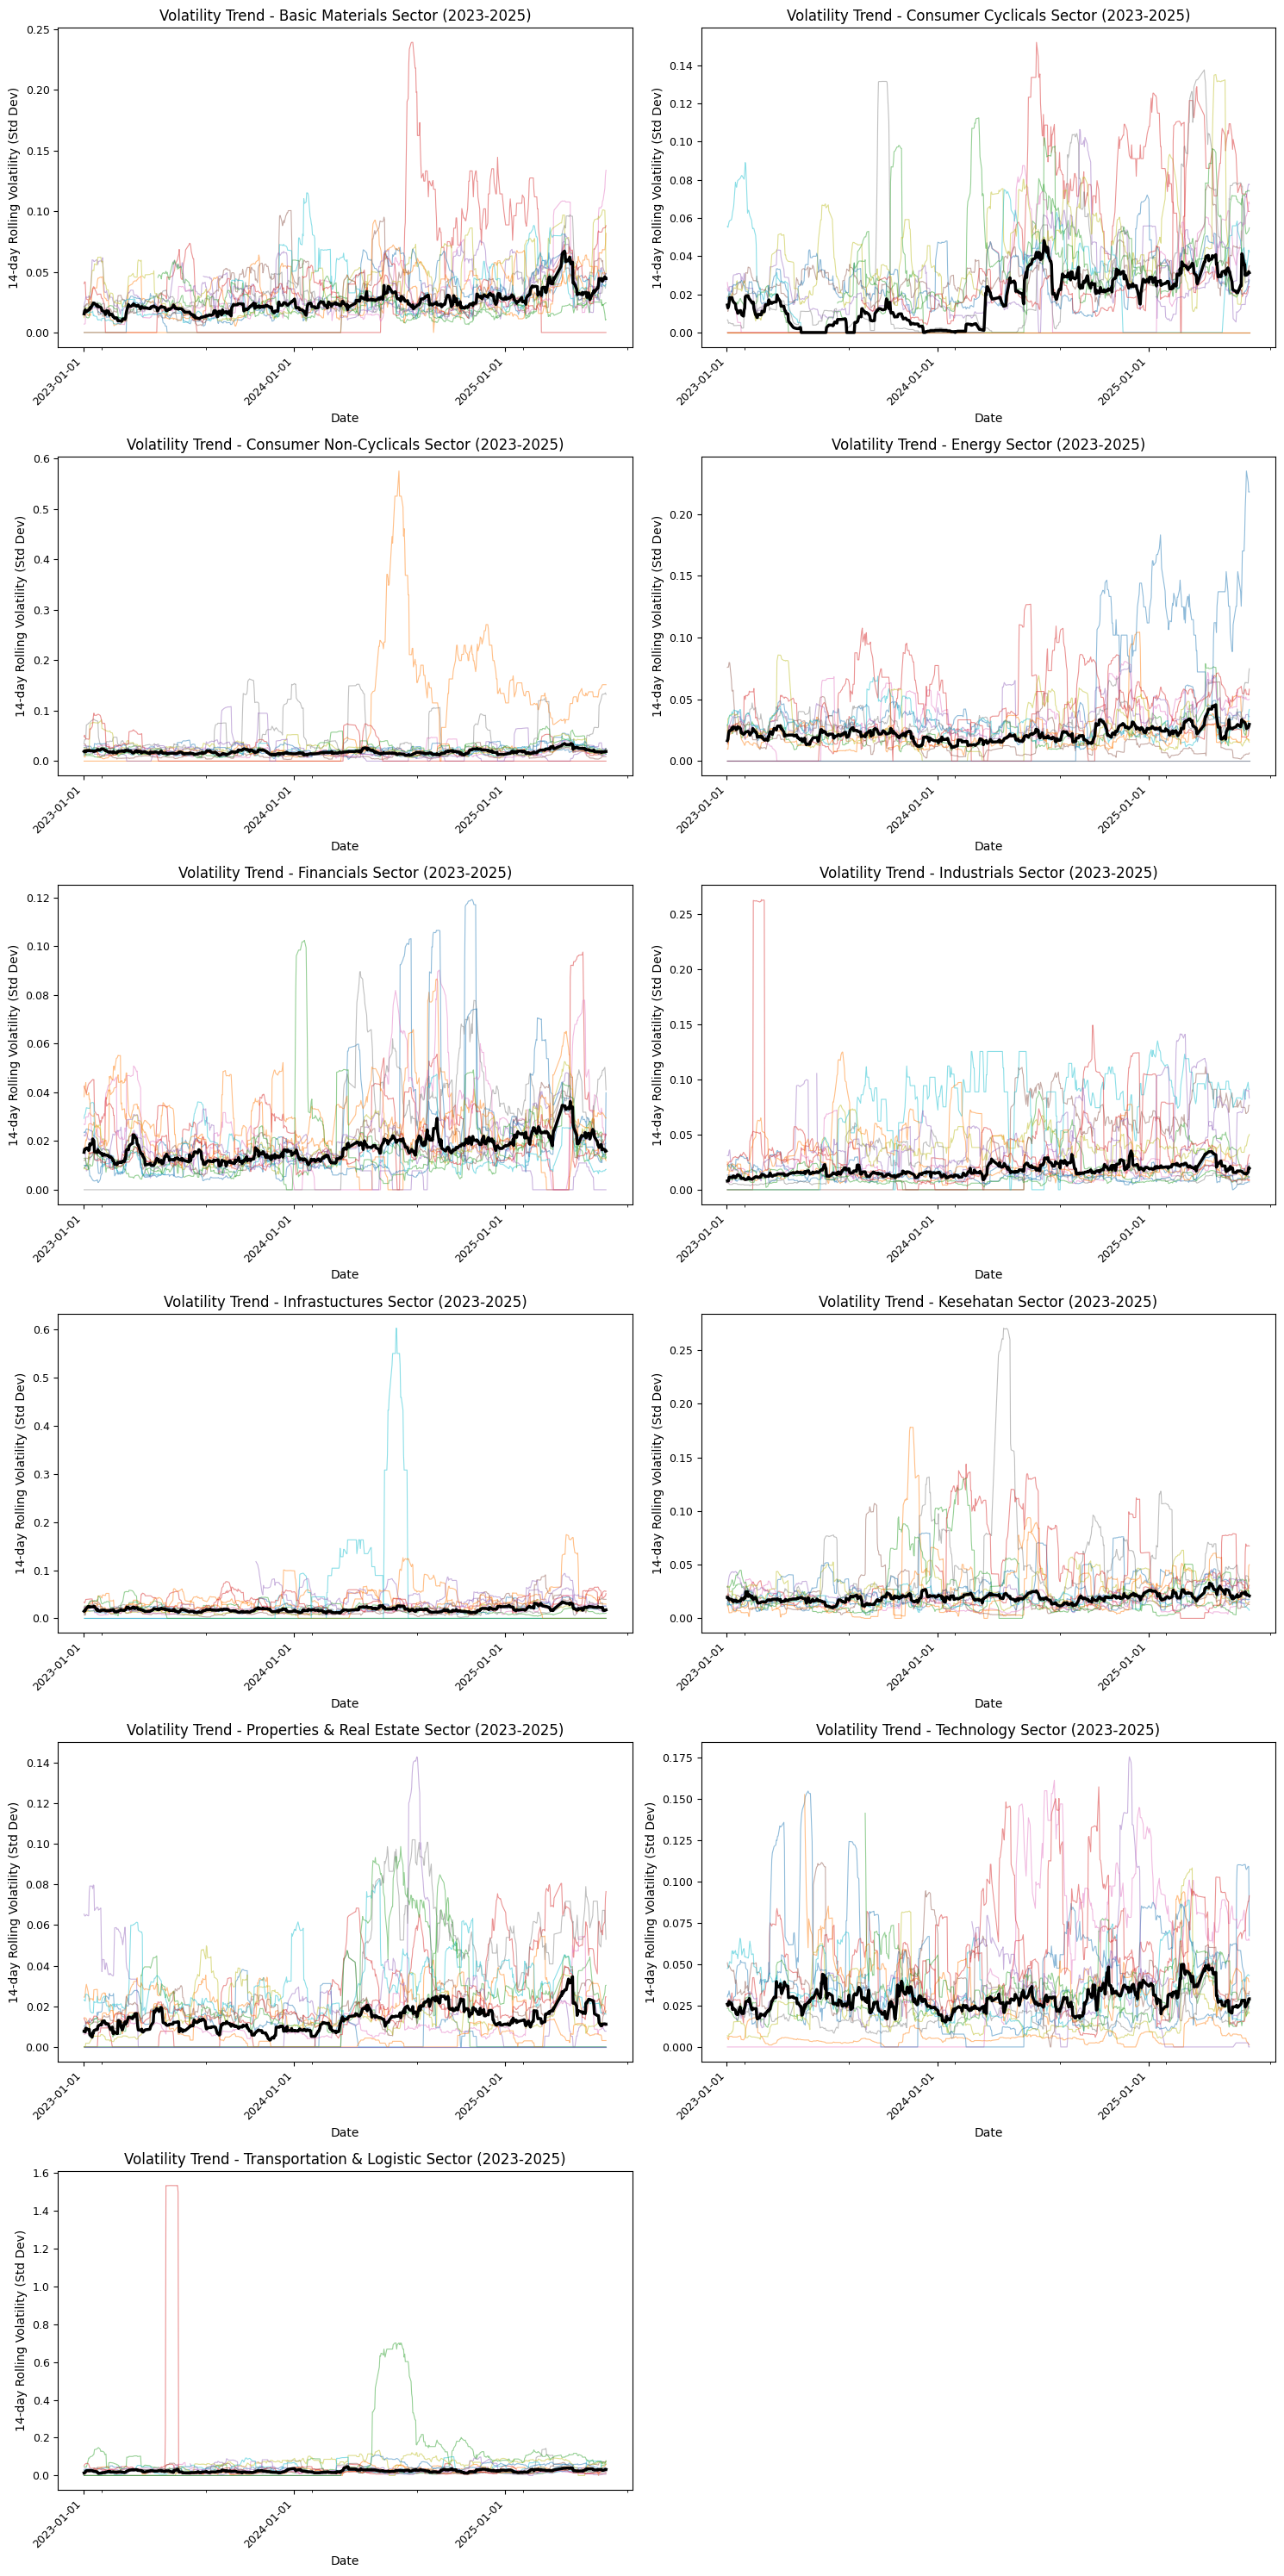


✅ Plot selesai dibuat.


In [ ]:
# @title **plot volatilitas Sektor vs Volatilitas Ticker**

# prompt: Bisakah anda buatkan subplots per sektor, jadi untuk melihat apakah sector volatility (sector_vol) terlihat membaur / mewakili tiap ticker nya (pada df dilakukan ini terlebih dahulu     # Hitung return harian per ticker
#     df_copy['Return'] = df_copy.groupby('Ticker')['Close'].pct_change()
#     # Hitung rolling volatility (standar deviasi dari return) per ticker
#     df_copy['Volatility_Individual'] = df_copy.groupby('Ticker')['Return'].rolling(window=14).std().reset_index(0, drop=True)
# ), di line plot saja tiap ticker tapi tidak begitu jelas, di tambah line  sector volatility yang menonjol, buat plot untuk 2023-2025 saja

import matplotlib.pyplot as plt
import seaborn as sns

# Gabungkan kembali sector_vol dengan df asli untuk mendapatkan data ticker individu
# Pastikan kolom Date dalam format datetime untuk penggabungan
df['Date'] = pd.to_datetime(df['Date'])
sector_vol['Date'] = pd.to_datetime(sector_vol['Date'])

# Merge sector_vol dengan df asli berdasarkan Date dan Sector
# Kita perlu melakukan kalkulasi individual volatility di df asli atau menggabungkan dengan hasil kalkulasi sebelumnya
# Berdasarkan code sebelumnya, df sudah memiliki kolom 'Return' dan 'Volatility_Individual'
# Jadi, kita merge df asli dengan sector_vol
merged_df = pd.merge(
    df,
    sector_vol[['Date', 'Sector', 'SectorVolatility_14d']],
    on=['Date', 'Sector'],
    how='left' # Gunakan left merge agar semua data ticker tetap ada
)

# Pastikan 'Volatility_Individual' sudah dihitung di df asli atau hitung ulang
# Jika belum, tambahkan kode ini:
if 'Return' not in merged_df.columns:
    merged_df['Return'] = merged_df.groupby('Ticker')['Close'].pct_change()
if 'Volatility_Individual' not in merged_df.columns:
    merged_df['Volatility_Individual'] = merged_df.groupby('Ticker')['Return'].rolling(window=14).std().reset_index(0, drop=True)

# Hapus baris yang memiliki NaN pada Volatility_Individual (awal periode rolling)
merged_df = merged_df.dropna(subset=['Volatility_Individual', 'SectorVolatility_14d']).reset_index(drop=True)

# Filter data untuk periode 2023-2025
merged_df_filtered = merged_df[(merged_df['Date'].dt.year >= 2023) & (merged_df['Date'].dt.year <= 2025)].copy()

# Dapatkan daftar sektor unik
unique_sectors = merged_df_filtered['Sector'].unique()
num_sectors = len(unique_sectors)

# Tentukan jumlah baris dan kolom untuk subplot
n_cols = 2  # Misalnya 2 kolom per baris
n_rows = (num_sectors + n_cols - 1) // n_cols

# Buat subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharey=False) # sharey=False agar skala y bisa berbeda
axes = axes.flatten() # Agar mudah diakses

print(f"\n📈 Membuat plot volatilitas per sektor ({num_sectors} sektor)...")

# Loop melalui setiap sektor dan buat plot
for i, sector in enumerate(unique_sectors):
    ax = axes[i]
    sector_data = merged_df_filtered[merged_df_filtered['Sector'] == sector]

    # Plot Volatilitas Individual Ticker
    # Ambil daftar ticker unik di sektor ini
    tickers_in_sector = sector_data['Ticker'].unique()
    for ticker in tickers_in_sector:
        ticker_data = sector_data[sector_data['Ticker'] == ticker]
        ax.plot(ticker_data['Date'], ticker_data['Volatility_Individual'], label=ticker, linewidth=0.8, alpha=0.5) # Ticker individu lebih tipis

    # Plot Volatilitas Sektor (rata-rata dari semua ticker di sektor tersebut)
    # Ambil hanya satu baris per tanggal untuk menghindari duplikasi garis sektor
    sector_volatility_data = sector_data[['Date', 'SectorVolatility_14d']].drop_duplicates(subset=['Date']).sort_values(by='Date')
    ax.plot(sector_volatility_data['Date'], sector_volatility_data['SectorVolatility_14d'], label=f'{sector} (Avg Volatility)', color='black', linewidth=2.5) # Garis sektor lebih tebal dan hitam

    # Atur judul dan label sumbu
    ax.set_title(f'Volatility Trend - {sector} Sector (2023-2025)', fontsize=12)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('14-day Rolling Volatility (Std Dev)', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)

    # Tambahkan legenda
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8) # Legenda di luar plot

    # Atur format tanggal pada sumbu x
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator()) # Atur major ticks setiap tahun
    ax.xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator(interval=6)) # Atur minor ticks setiap 6 bulan
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotasi label tanggal

# Sembunyikan subplot yang tidak digunakan jika jumlah sektor ganjil
if num_sectors < len(axes):
    for j in range(num_sectors, len(axes)):
        fig.delaxes(axes[j])

# Atur layout agar tidak tumpang tindih
plt.tight_layout()

# Tampilkan plot
plt.show()

print("\n✅ Plot selesai dibuat.")


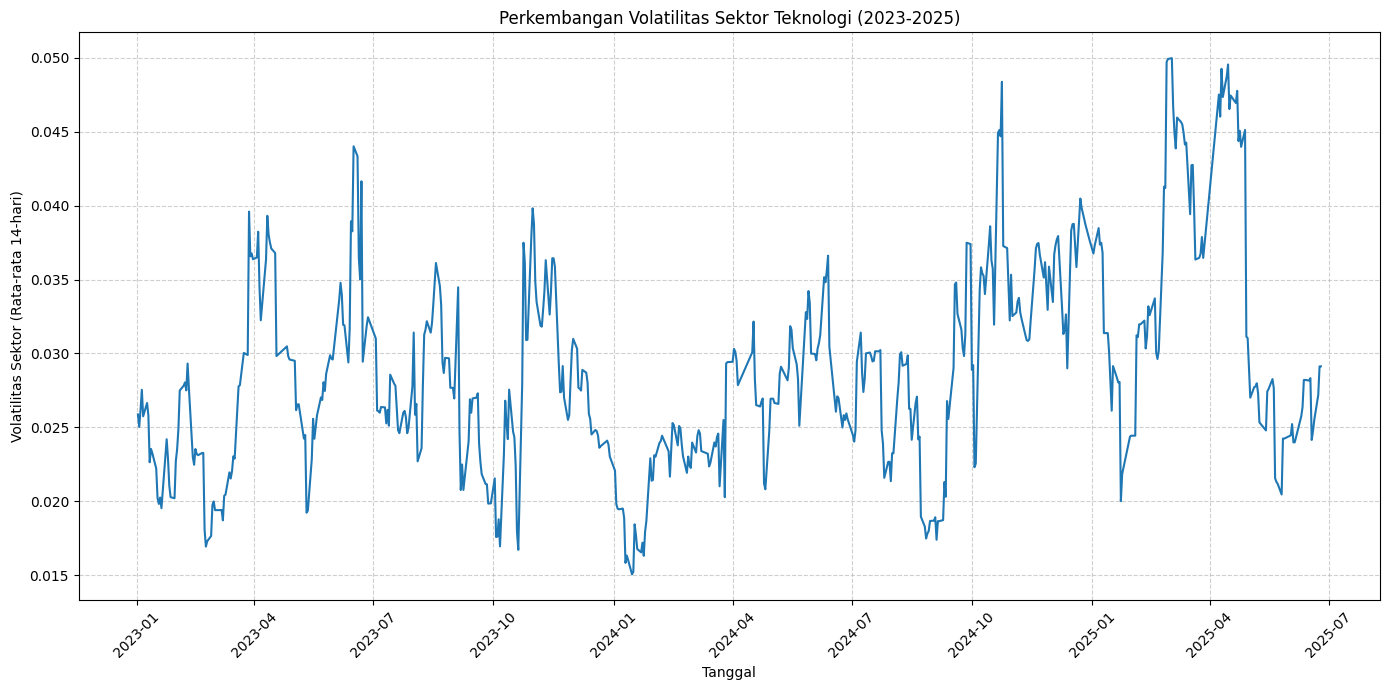

In [ ]:
# @title **Contoh Plot Volatilitas (Sektor Teknologi)**
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data untuk sector 'Technology' dan rentang tahun 2023-2025
df_tech_filtered = sector_vol[
    (sector_vol['Sector'] == 'Technology') &
    (sector_vol['Date'].dt.year >= 2023) &
    (sector_vol['Date'].dt.year <= 2025)
]

# Plot Volatilitas Sektor Teknologi dari 2023 hingga 2025
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_tech_filtered, x='Date', y='SectorVolatility_14d')
plt.title('Perkembangan Volatilitas Sektor Teknologi (2023-2025)')
plt.xlabel('Tanggal')
plt.ylabel('Volatilitas Sektor (Rata-rata 14-hari)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout() # Menyesuaikan layout agar tidak terpotong
plt.show()

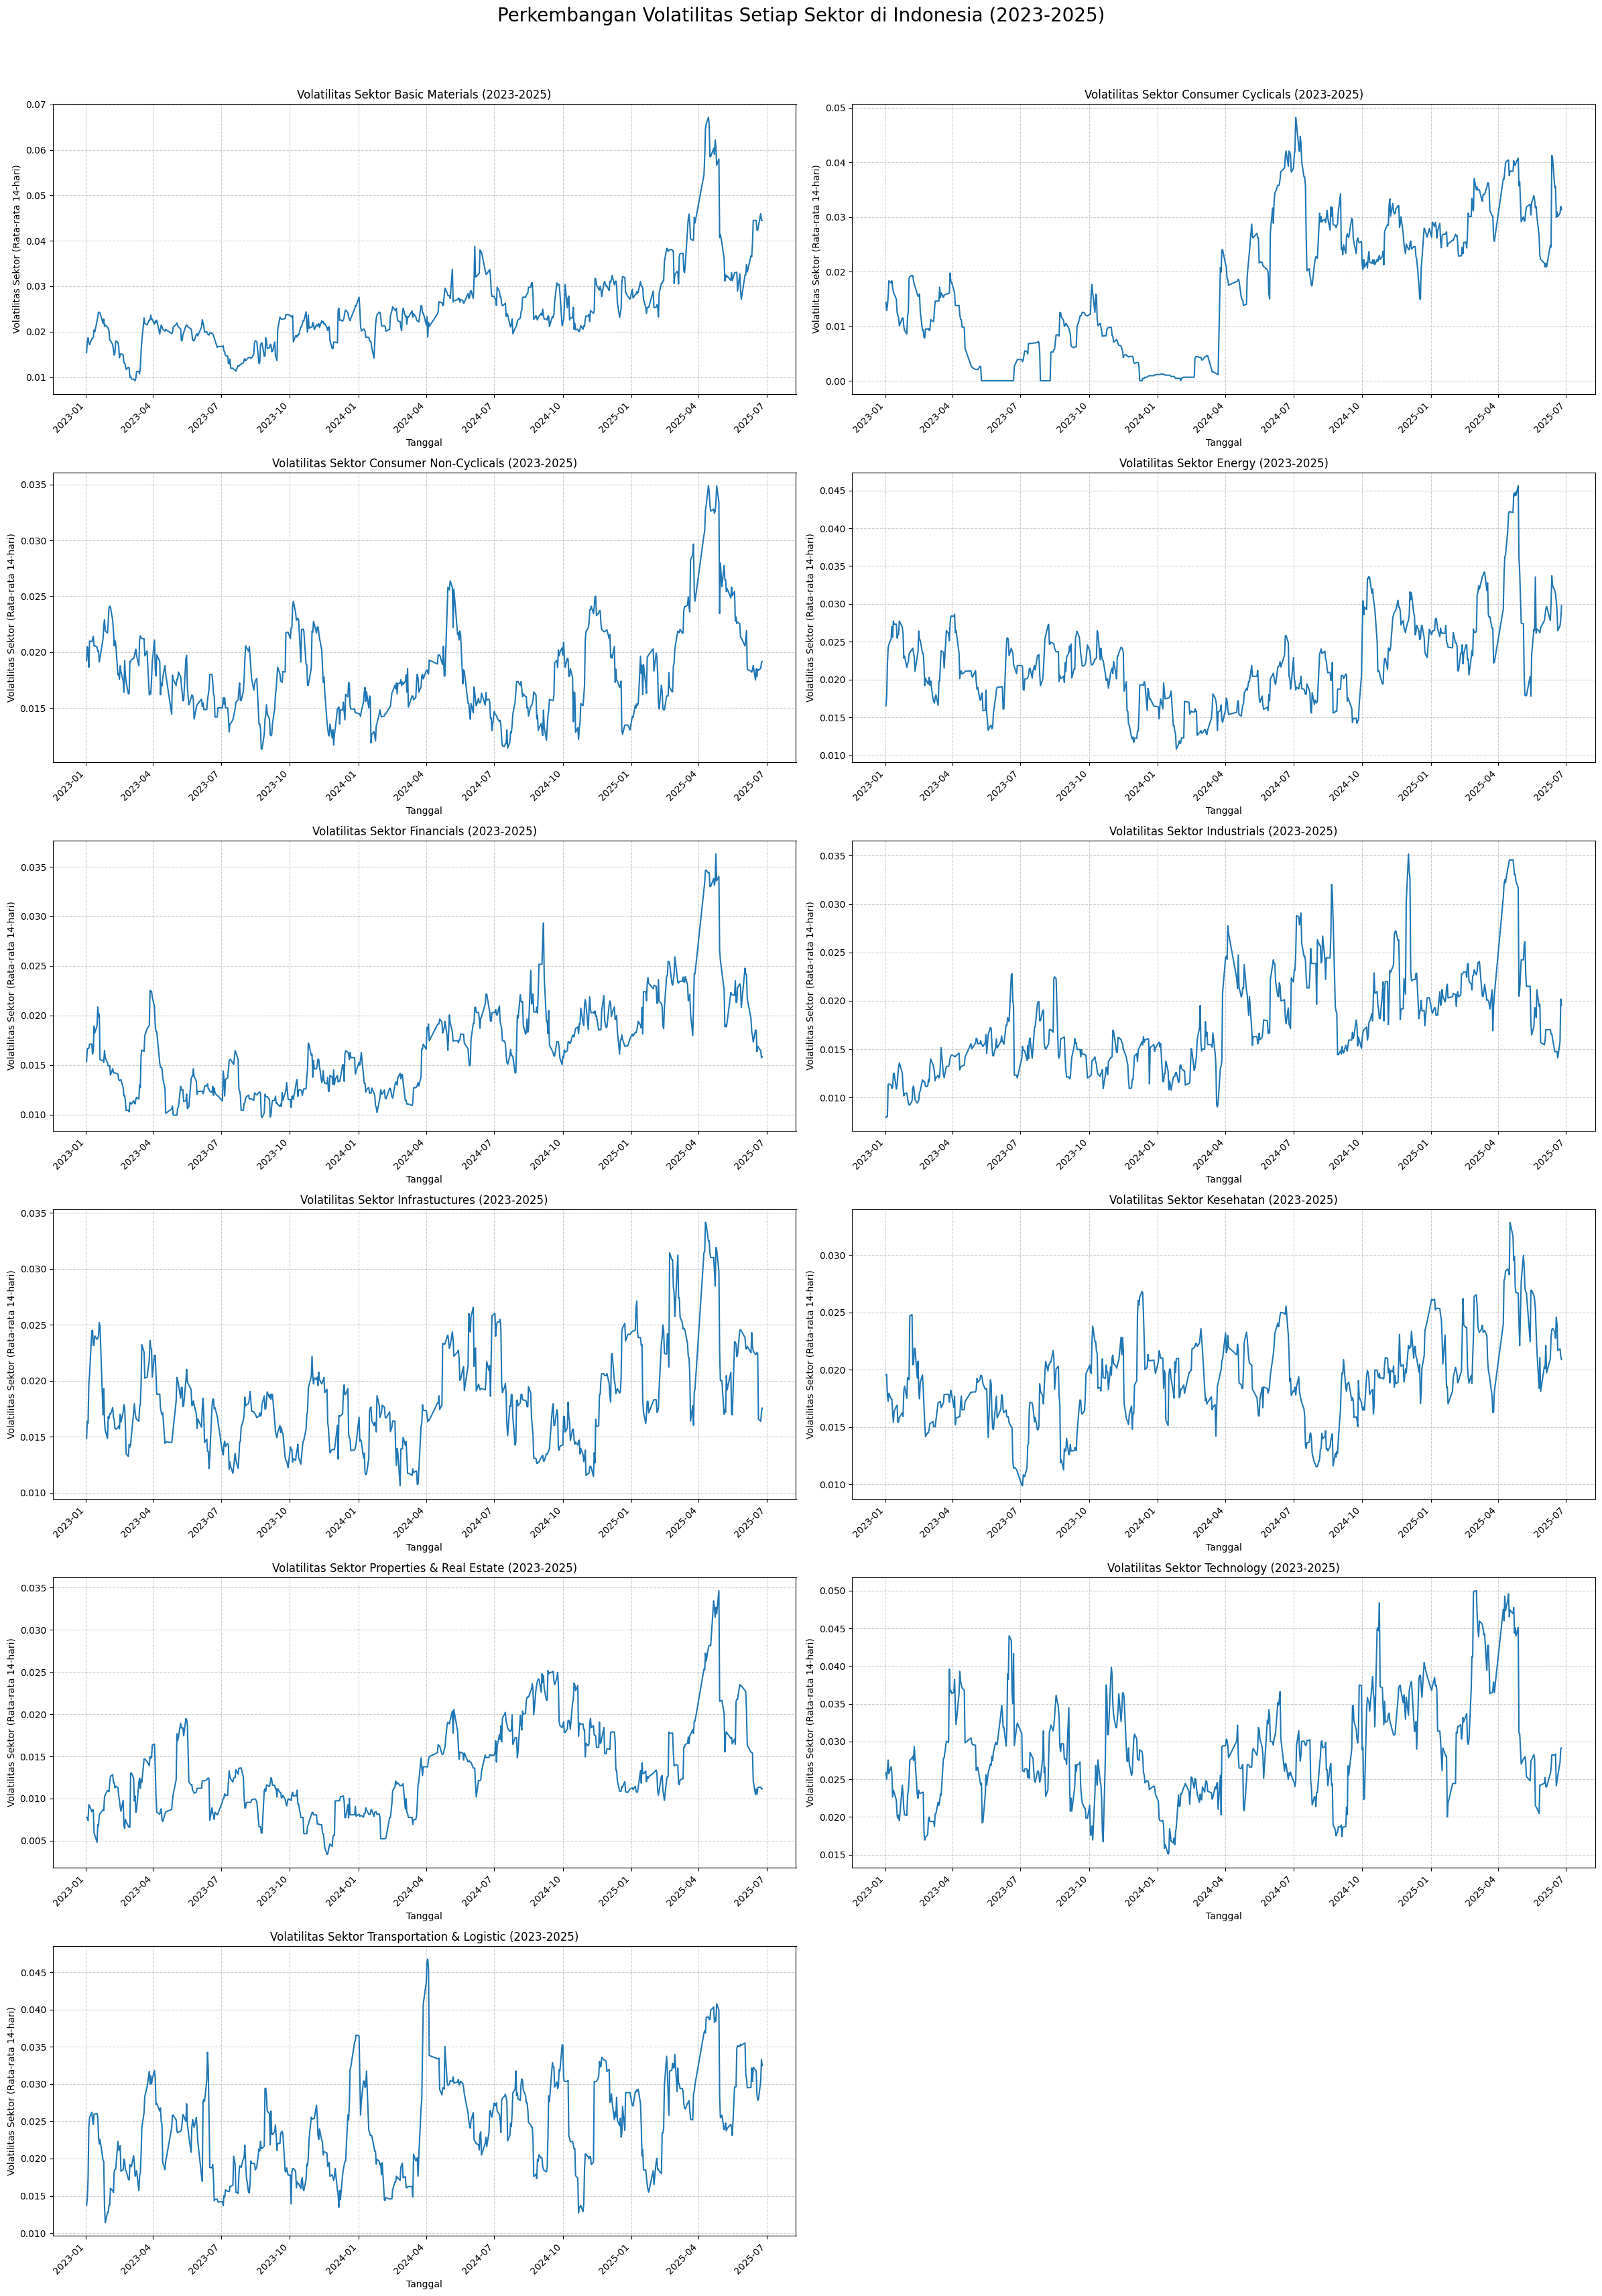

In [ ]:
# @title **Plot seluruh sektor**
# Filter data untuk rentang tahun 2023-2025
df_filtered_years = sector_vol[
    (sector_vol['Date'].dt.year >= 2023) &
    (sector_vol['Date'].dt.year <= 2025)
]

# Dapatkan daftar unik sektor yang ada di data yang sudah difilter
unique_sectors = df_filtered_years['Sector'].unique()

# Hitung jumlah sektor untuk menentukan layout subplot
n_sectors = len(unique_sectors)
n_cols = 2  # Jumlah kolom subplot, bisa disesuaikan
n_rows = (n_sectors + n_cols - 1) // n_cols # Hitung jumlah baris

# Atur ukuran figure keseluruhan
plt.figure(figsize=(12 * n_cols, 6 * n_rows)) # Ukuran figure lebih besar untuk menampung banyak subplot

# Buat subplot untuk setiap sektor
for i, sector in enumerate(unique_sectors):
    # Pilih data untuk sektor tertentu
    df_sector = df_filtered_years[df_filtered_years['Sector'] == sector]

    # Buat subplot
    plt.subplot(n_rows, n_cols, i + 1)

    # Buat plot garis menggunakan seaborn
    sns.lineplot(data=df_sector, x='Date', y='SectorVolatility_14d')

    # Tambahkan judul dan label
    plt.title(f'Volatilitas Sektor {sector} (2023-2025)')
    plt.xlabel('Tanggal')
    plt.ylabel('Volatilitas Sektor (Rata-rata 14-hari)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right') # Rotasi label sumbu x agar tidak tumpang tindih

# Atur layout agar subplot tidak tumpang tindih
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Menyesuaikan layout dengan sedikit ruang di atas untuk judul utama

# Tambahkan judul utama untuk seluruh figure
plt.suptitle('Perkembangan Volatilitas Setiap Sektor di Indonesia (2023-2025)', fontsize=20, y=0.98)

# Tampilkan plot
plt.show()


# ***Data Geopolitik***
---

## **Geopolitik 2**

In [ ]:
# download data geopolitic sumber ke 2
!gdown 126Q8cBVmMOljp4SSb8tybhHQsAf6B4iV

# download data volatilitas sektor 7d
!gdown 1YscGkU7fVnUDF6yfHl7LwbTcx6e7Nf2S

Downloading...
From: https://drive.google.com/uc?id=126Q8cBVmMOljp4SSb8tybhHQsAf6B4iV
To: /content/dailyGeoIndex.csv
100% 266k/266k [00:00<00:00, 32.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YscGkU7fVnUDF6yfHl7LwbTcx6e7Nf2S
To: /content/sector_volatility7d.csv
100% 1.66M/1.66M [00:00<00:00, 55.6MB/s]


In [ ]:
import pandas as pd

df_geo = pd.read_csv('/content/dailyGeoIndex.csv')
sector_vol = pd.read_csv('/content/sector_volatility7d.csv')
df_geo.head()

date  ArticlesCount_Daily   GPR_Daily  GPR_Action_Daily  \
0  2015-01-01                  533   74.579384         49.566547   
1  2015-01-02                  620  106.857018        117.180916   
2  2015-01-03                  868   53.428509         60.873203   
3  2015-01-04                  402   16.480436         16.429708   
4  2015-01-05                  592  100.719963        111.566589   

   GPR_Threat_Daily  
0         82.686790  
1         97.740456  
2         44.427479  
3         13.703999  
4         74.446053

ArticlesCount_Daily : berapa banyak articles yang memuat berita konflik ini di hari itu
GPR_Daily : Geopolitic risk daily

1. Ancaman Perang (War Threats)
2. Ancaman terhadap Perdamaian (Peace Threats)
3. Peningkatan Aktivitas Militer (Military Buildups)
4. Ancaman Nuklir (Nuclear Threats)
5. Ancaman Teror (Terror Threats)
6. Permulaan Perang (Beginning of War)
7. Eskalasi Perang (Escalation of War)
8. Aksi Teror (Terror Acts)

GPR_Action_Daily : geopolitic risk daily dihitung dari berita dengan poin 6,7,8
GPR_Threat_Daily : geopolitic risk daily dihitung dari berita dengan poin 1-5

In [ ]:
# Pastikan kolom 'Date' dalam format datetime
df_geo['date'] = pd.to_datetime(df_geo['date'])

# Urutkan data berdasarkan tanggal (penting untuk kalkulasi rolling)
df_geo = df_geo.sort_values(by='date')

# Hitung rolling sum untuk setiap kolom yang relevan
columns_to_roll = [col for col in df_geo.columns if col not in ['date']]

for col in columns_to_roll:
    # Buat nama kolom baru untuk rolling sum
    new_col_name = f'{col}_RollingSum_7d'
    # Hitung rolling sum dengan window 7 hari
    df_geo[new_col_name] = df_geo[col].rolling(window=7).sum()




📈 Membuat plot trend untuk setiap kolom data geopolitik (4 kolom)...


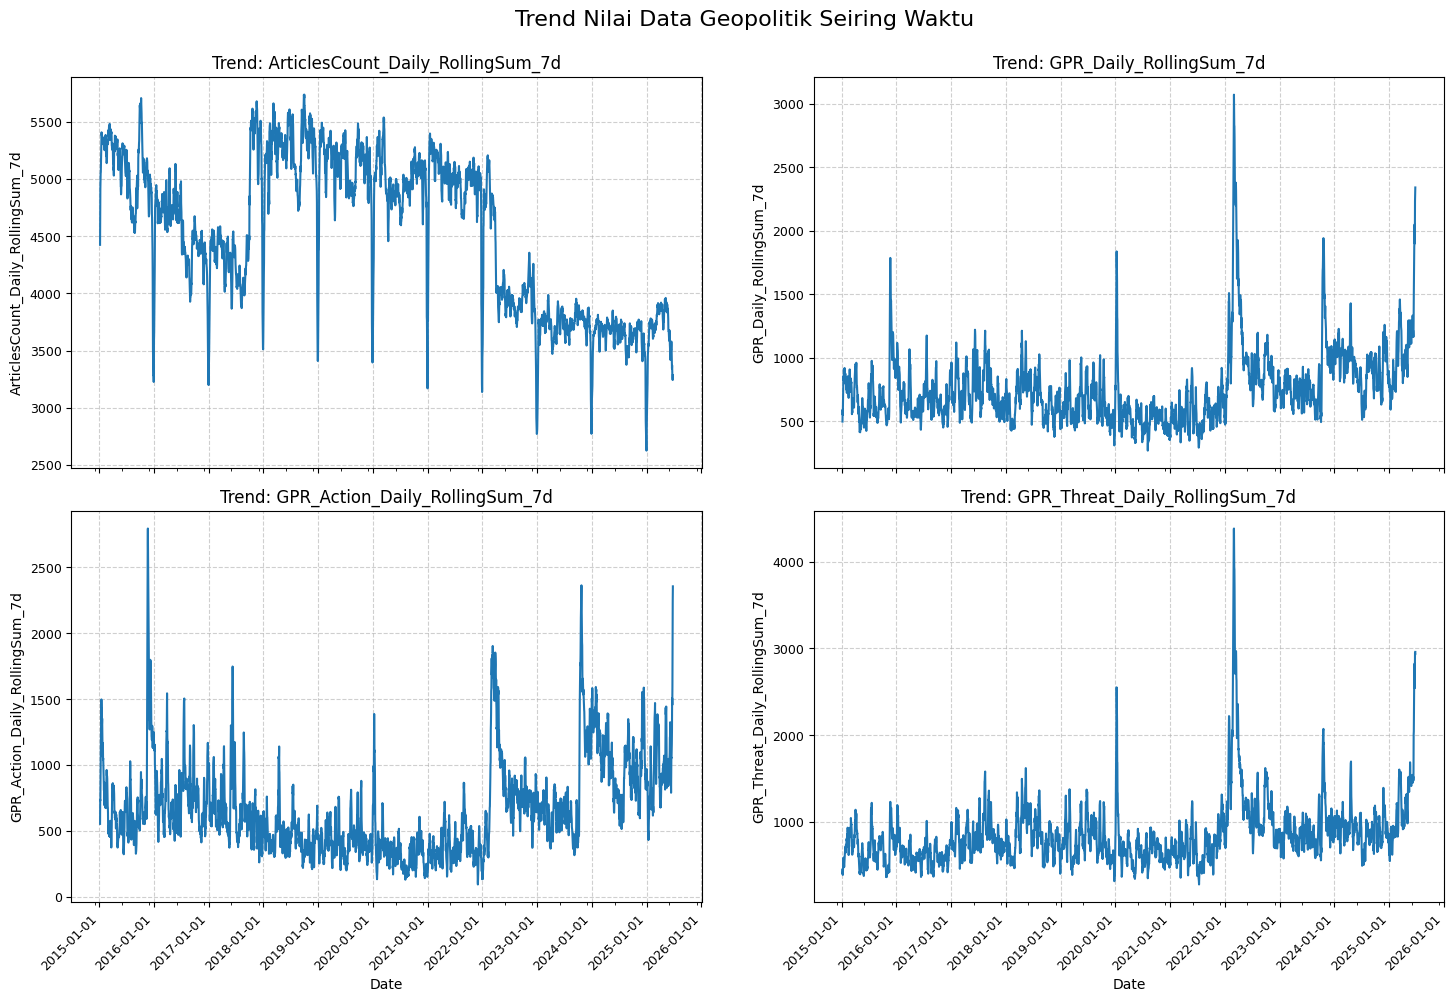


✅ Plot setiap kolom data geopolitik selesai dibuat.


In [ ]:
# @title plot data berita

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Ubah kolom 'Date' menjadi datetime
df_geo['Date'] = pd.to_datetime(df_geo['date'])

# Urutkan data berdasarkan tanggal
df_geo = df_geo.sort_values(by='Date')

# Dapatkan daftar kolom numerik yang ingin divisualisasikan, kecuali 'Date'
numeric_cols = df_geo.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = numeric_cols[-4:]

# Hitung jumlah kolom numerik
num_cols = len(numeric_cols)

# Tentukan jumlah baris dan kolom untuk subplot
n_cols = 2  # Misalnya 2 kolom per baris
n_rows = (num_cols + n_cols - 1) // n_cols

# Buat figure dan axes untuk subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharex=True) # sharex=True agar sumbu x sama
axes = axes.flatten() # Agar mudah diakses (jika hanya 1 baris atau 1 kolom)

print(f"\n📈 Membuat plot trend untuk setiap kolom data geopolitik ({num_cols} kolom)...")

# Loop melalui setiap kolom numerik dan buat plot
for i, col in enumerate(numeric_cols):
    ax = axes[i]

    # Buat plot garis menggunakan seaborn
    sns.lineplot(data=df_geo, x='Date', y=col, ax=ax)

    # Atur judul dan label sumbu
    ax.set_title(f'Trend: {col}', fontsize=12)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel(col, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Atur format tanggal pada sumbu x
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator()) # Atur major ticks setiap tahun
    ax.xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator(interval=6)) # Atur minor ticks setiap 6 bulan

# Sembunyikan subplot yang tidak digunakan jika jumlah kolom ganjil
if num_cols < len(axes):
    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

# Atur layout agar tidak tumpang tindih dan putar label x jika perlu (setelah subplot dibuat)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Sesuaikan layout
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotasi label tanggal

# Tambahkan judul utama untuk seluruh figure
plt.suptitle('Trend Nilai Data Geopolitik Seiring Waktu', fontsize=16, y=0.98)


# Tampilkan plot
plt.show()

print("\n✅ Plot setiap kolom data geopolitik selesai dibuat.")

In [ ]:
# Pastikan kolom 'Date' dalam format datetime di kedua DataFrame
sector_vol['Date'] = pd.to_datetime(sector_vol['Date'])
df_geo['Date'] = pd.to_datetime(df_geo['date'])
df_geo = df_geo.drop(columns= 'date')

# Gabungkan df_geo ke dalam sector_vol berdasarkan kolom 'Date'
# Gunakan 'left' merge agar semua baris dari sector_vol tetap ada
sector_vol_with_geo = pd.merge(
    sector_vol,
    df_geo,
    on='Date',
    how='left'
)

print("\n📊 Hasil Penggabungan sector_vol dengan data geopolitik (5 baris pertama):")
sector_vol_with_geo.head()


📊 Hasil Penggabungan sector_vol dengan data geopolitik (5 baris pertama):


Date           Sector  SectorVolatility_7d  SectorReturn_avg  \
0 2015-01-13  Basic Materials             0.016909         -0.001049   
1 2015-01-14  Basic Materials             0.019377         -0.018419   
2 2015-01-15  Basic Materials             0.018848          0.000000   
3 2015-01-16  Basic Materials             0.019909          0.004587   
4 2015-01-19  Basic Materials             0.014540         -0.004497   

   ArticlesCount_Daily   GPR_Daily  GPR_Action_Daily  GPR_Threat_Daily  \
0                  765  151.555389        259.009521         79.214493   
1                  787   88.391258        151.061447         77.000107   
2                  923  132.789825        257.606415         23.874355   
3                  870  156.109512        258.116364         82.318504   
4                  606  120.258240        130.786987        109.089256   

   ArticlesCount_Daily_RollingSum_7d  GPR_Daily_RollingSum_7d  \
0                             5131.0               846.618202   
1                             5203.0               856.249107   
2                             5301.0               820.399117   
3                             5352.0               911.794243   
4                             5385.0               835.463226   

   GPR_Action_Daily_RollingSum_7d  GPR_Threat_Daily_RollingSum_7d  
0                     1268.447723                      570.895947  
1                     1327.135147                      586.256805  
2                     1352.574860                      476.579464  
3                     1497.789635                      531.991947  
4                     1322.565681                      494.376507

In [ ]:
print("\n📊 Cek nilai NaN di kolom hasil merge:")
print(sector_vol_with_geo.isnull().sum())


📊 Cek nilai NaN di kolom hasil merge:
Date                                 0
Sector                               0
SectorVolatility_7d                  0
SectorReturn_avg                     0
ArticlesCount_Daily                  0
GPR_Daily                            0
GPR_Action_Daily                     0
GPR_Threat_Daily                     0
ArticlesCount_Daily_RollingSum_7d    0
GPR_Daily_RollingSum_7d              0
GPR_Action_Daily_RollingSum_7d       0
GPR_Threat_Daily_RollingSum_7d       0
dtype: int64


In [ ]:
# Korelasi antara Volatilitas Sektor dan Variabel Geopolitik per Sektor

# Ambil daftar sektor unik
unique_sectors_merged = sector_vol_with_geo['Sector'].unique()

# Tentukan kolom variabel geopolitik
geopolitical_cols = ['ArticlesCount_Daily_RollingSum_7d', 'GPR_Daily_RollingSum_7d',
       'GPR_Action_Daily_RollingSum_7d', 'GPR_Threat_Daily_RollingSum_7d']

print("\n🔬 Menghitung korelasi antara SectorVolatility_7d dan variabel geopolitik per sektor...")
print("=" * 80)

# Buat dictionary untuk menyimpan hasil korelasi per sektor
correlation_results = {}

# Loop melalui setiap sektor
for sector in unique_sectors_merged:
    print(f"🧬 Sektor: {sector}")
    # Filter data untuk sektor saat ini
    sector_data_corr = sector_vol_with_geo[sector_vol_with_geo['Sector'] == sector].copy()

    # Pilih kolom yang relevan untuk korelasi: SectorVolatility_7d dan kolom geopolitik
    corr_cols = ['SectorVolatility_7d'] + geopolitical_cols

    # Pastikan semua kolom yang dibutuhkan ada di data sektor
    # Ini penting jika ada sektor yang mungkin tidak memiliki data untuk semua kolom geo (meskipun tidak mungkin terjadi setelah merge left)
    # atau jika ada NaN dalam jumlah besar yang menyebabkan korelasi tidak bisa dihitung.
    # Untuk memastikan, kita bisa drop rows dengan NaN pada kolom yang relevan
    sector_data_corr = sector_data_corr.dropna(subset=corr_cols)

    # Hitung matriks korelasi
    if not sector_data_corr.empty:
        correlation_matrix = sector_data_corr[corr_cols].corr()

        # Ambil baris korelasi untuk 'SectorVolatility_7d'
        volatility_correlations = correlation_matrix.loc['SectorVolatility_7d', geopolitical_cols]

        # Simpan hasil
        correlation_results[sector] = volatility_correlations

        # Tampilkan hasil untuk sektor ini
        print(abs(volatility_correlations).sort_values(ascending= False).to_string()) # Menggunakan to_string untuk format yang rapi
        print("-" * 40)
    else:
        print("   Tidak ada data yang cukup (atau data setelah dropna) untuk menghitung korelasi.")
        correlation_results[sector] = None # Atau dictionary kosong

print("=" * 80)
print("✅ Analisis korelasi per sektor selesai.")



🔬 Menghitung korelasi antara SectorVolatility_7d dan variabel geopolitik per sektor...
🧬 Sektor: Basic Materials
ArticlesCount_Daily_RollingSum_7d    0.056183
GPR_Threat_Daily_RollingSum_7d       0.037750
GPR_Action_Daily_RollingSum_7d       0.036572
GPR_Daily_RollingSum_7d              0.007068
----------------------------------------
🧬 Sektor: Consumer Cyclicals
ArticlesCount_Daily_RollingSum_7d    0.137961
GPR_Threat_Daily_RollingSum_7d       0.070878
GPR_Daily_RollingSum_7d              0.059321
GPR_Action_Daily_RollingSum_7d       0.004041
----------------------------------------
🧬 Sektor: Consumer Non-Cyclicals
GPR_Threat_Daily_RollingSum_7d       0.065661
GPR_Daily_RollingSum_7d              0.064385
ArticlesCount_Daily_RollingSum_7d    0.053923
GPR_Action_Daily_RollingSum_7d       0.048766
----------------------------------------
🧬 Sektor: Energy
GPR_Threat_Daily_RollingSum_7d       0.332068
GPR_Daily_RollingSum_7d              0.308150
ArticlesCount_Daily_RollingSum_7d    0.2

In [ ]:
if correlation_results:
    correlation_df = pd.DataFrame(correlation_results).T # Transpose agar sektor menjadi index
    correlation_df = correlation_df.sort_index() # Urutkan berdasarkan nama sektor

    print("\n📊 Ringkasan Hasil Korelasi (Sektor vs. Variabel Geopolitik):")
    print(correlation_df.to_string())


📊 Ringkasan Hasil Korelasi (Sektor vs. Variabel Geopolitik):
                           ArticlesCount_Daily_RollingSum_7d  GPR_Daily_RollingSum_7d  GPR_Action_Daily_RollingSum_7d  GPR_Threat_Daily_RollingSum_7d
Basic Materials                                    -0.056183                 0.007068                       -0.036572                        0.037750
Consumer Cyclicals                                  0.137961                 0.059321                       -0.004041                        0.070878
Consumer Non-Cyclicals                              0.053923                 0.064385                        0.048766                        0.065661
Energy                                             -0.294959                 0.308150                        0.179445                        0.332068
Financials                                          0.107620                -0.105807                       -0.108359                       -0.080723
Industrials                           


📊 Membuat visualisasi korelasi per sektor (11 sektor)...


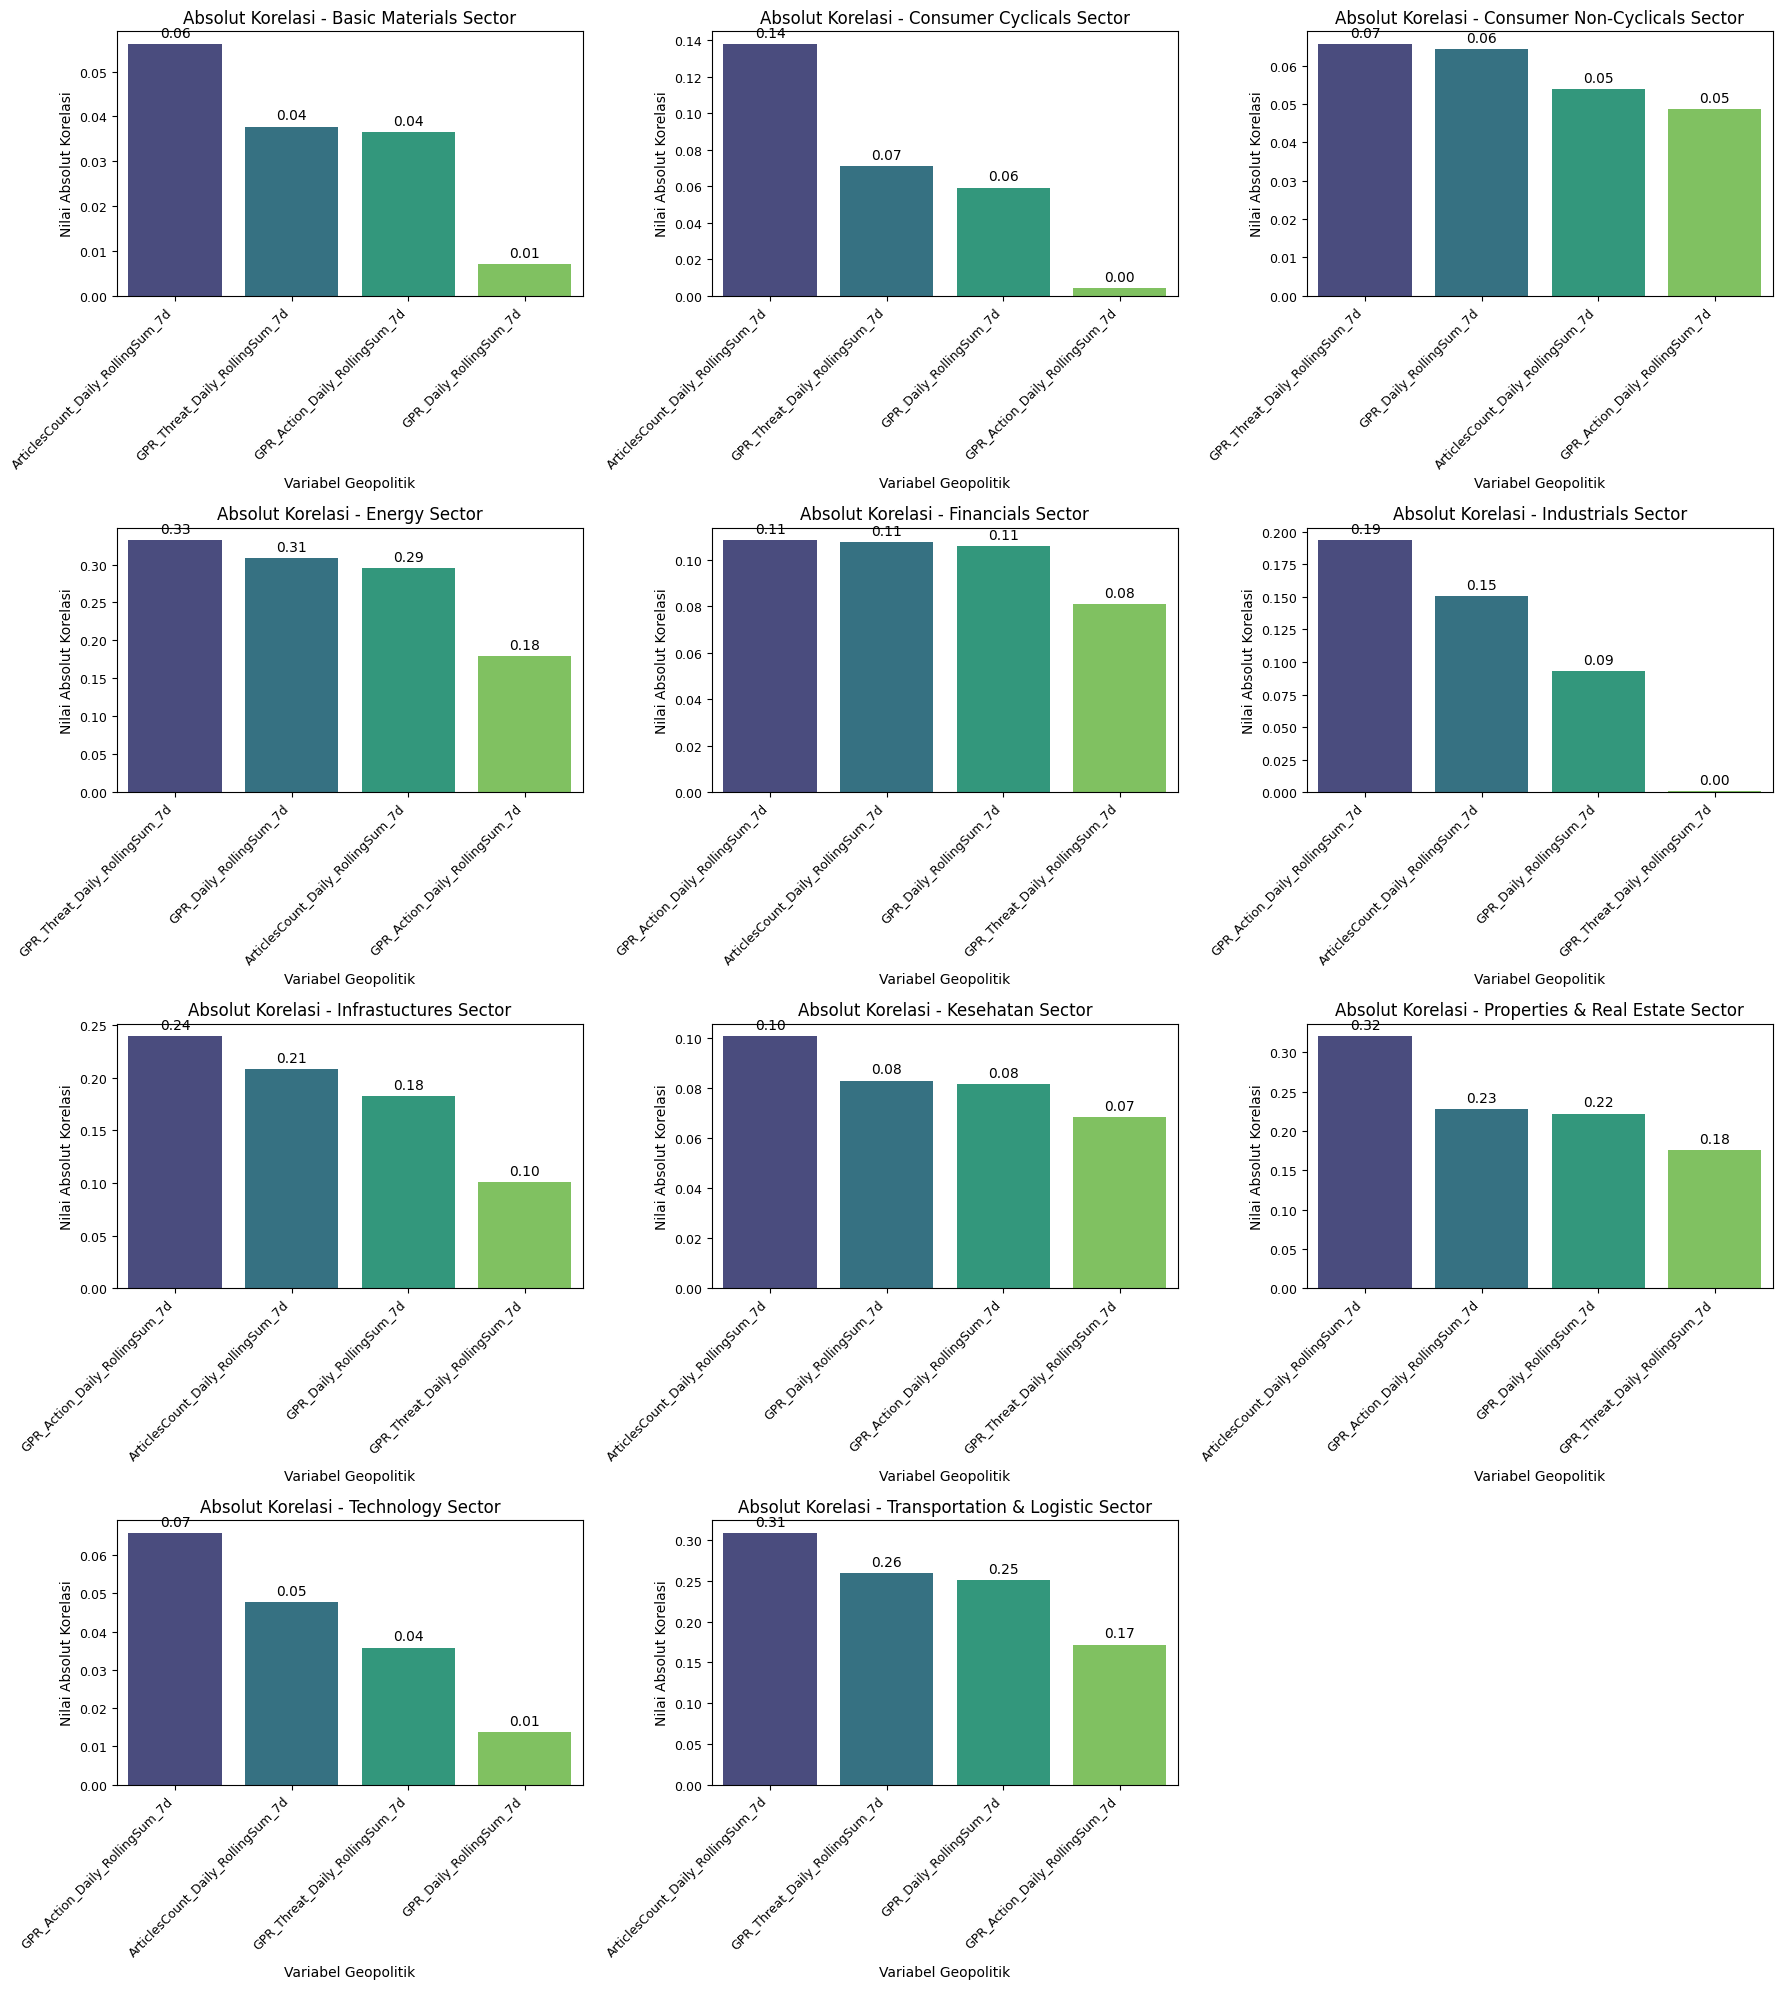


✅ Visualisasi korelasi selesai dibuat.


In [ ]:
# @title plot korelasi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Dapatkan daftar sektor unik dari DataFrame korelasi
unique_sectors_corr = correlation_df.index.unique()
num_sectors_corr = len(unique_sectors_corr)

# Tentukan jumlah baris dan kolom untuk subplot
n_cols_corr = 3  # Misalnya 3 kolom per baris
n_rows_corr = (num_sectors_corr + n_cols_corr - 1) // n_cols_corr

# Buat subplot
fig_corr, axes_corr = plt.subplots(n_rows_corr, n_cols_corr, figsize=(18, n_rows_corr * 5)) # Sesuaikan ukuran figure
axes_corr = axes_corr.flatten() # Agar mudah diakses

print(f"\n📊 Membuat visualisasi korelasi per sektor ({num_sectors_corr} sektor)...")

# Loop melalui setiap sektor dan buat plot bar
for i, sector in enumerate(unique_sectors_corr):
    ax = axes_corr[i]

    # Ambil data korelasi untuk sektor ini
    sector_corr_data = correlation_df.loc[sector]

    # Hitung nilai absolut dan urutkan
    abs_sector_corr_data = sector_corr_data.abs().sort_values(ascending=False)

    # Buat plot bar menggunakan seaborn
    sns.barplot(x=abs_sector_corr_data.index, y=abs_sector_corr_data.values, ax=ax, palette='viridis' )

    # Atur judul dan label sumbu
    ax.set_title(f'Absolut Korelasi - {sector} Sector', fontsize=12)
    ax.set_xlabel('Variabel Geopolitik', fontsize=10)
    ax.set_ylabel('Nilai Absolut Korelasi', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotasi label sumbu x

    # Tambahkan nilai di atas bar (opsional)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)


# Sembunyikan subplot yang tidak digunakan
if num_sectors_corr < len(axes_corr):
    for j in range(num_sectors_corr, len(axes_corr)):
        fig_corr.delaxes(axes_corr[j])

# Atur layout agar tidak tumpang tindih
plt.tight_layout()

# Tampilkan plot
plt.show()

print("\n✅ Visualisasi korelasi selesai dibuat.")


In [ ]:
# simpan data gabungan sector dan geopolitics
sector_vol_with_geo.iloc[:,:8].to_csv("/content/sector_vol_with_geo_2_7d.csv", index=False)

# ***Link to Modeling***

https://colab.research.google.com/drive/1IKkb0K9HmIJA3w4N8gvchlNRnaH6_Z72?usp=sharing